## 📓 Predicting Berry Size
#### Given that berries are our primary food source on this island, being able to predict the size of a berry before harvesting it would be incredibly useful. This would allow us to prioritize which plants to tend to for the most substantial yield. In this section, we will build predictive models to estimate berry size based on other plant features.

### Business & Data Understanding 🧠

#### The primary goal is to accurately predict the average berry_size of a plant using its other known characteristics. This involves:

- Comparing different regression models to find the most accurate one.
- Investigating if model performance improves by focusing only on edible berries.
- Deriving a simple, explicit formula for on-the-go predictions without a computer.
- Assessing the model's performance without hard-to-measure features like soil_quality

In [29]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

In [30]:
# Load the dataset & convert to dataframe
df = pd.read_json("../data/complete.json")

# Set plot style
sns.set_style("whitegrid")

print(df.head())


        age  leaf_size berry_colour  berry_size  leaf_shape petal_colour  \
0  9.795552  16.083941         blue    8.734281       ovate         pink   
1  8.596144  17.515386         blue   10.270547  lanceolate        white   
2  9.446874  15.677807         blue    7.777643  lanceolate        white   
3  7.342407  13.285620       purple    8.435157       ovate        white   
4  8.103198  14.996667       purple    8.351162       ovate        white   

   petal_size      height  edible  soil_quality              species  
0    1.962667  397.119296   False      3.362384  berrius delphinorum  
1    5.170076  299.475406    True      5.948337       berrius actius  
2    3.996334  192.531378    True      4.888970       berrius actius  
3    2.483346  127.481779   False      3.221025       berrius codiae  
4    2.427108  154.036470   False      3.199550       berrius codiae  


Initial Data Understanding

--- Data Overview (Plants with Berries Only) ---
<class 'pandas.core.frame.DataFrame'>
Index: 438 entries, 0 to 499
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           438 non-null    float64
 1   leaf_size     438 non-null    float64
 2   berry_colour  438 non-null    object 
 3   berry_size    438 non-null    float64
 4   leaf_shape    438 non-null    object 
 5   petal_colour  438 non-null    object 
 6   petal_size    438 non-null    float64
 7   height        438 non-null    float64
 8   edible        438 non-null    bool   
 9   soil_quality  438 non-null    float64
 10  species       438 non-null    object 
dtypes: bool(1), float64(6), object(4)
memory usage: 38.1+ KB
None


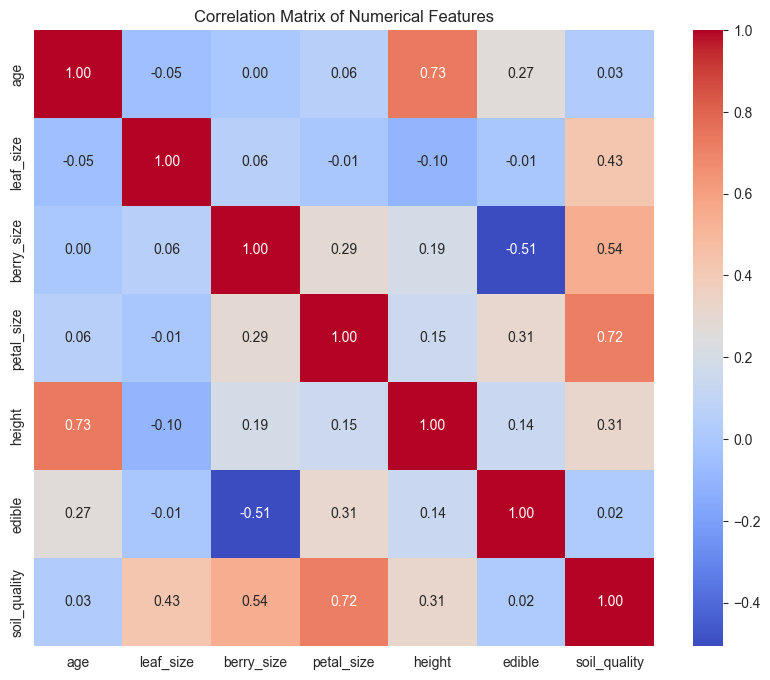

In [31]:
# Drop rows where berry_size is 0, as these are likely plants without berries yet.
df_berries = df[df['berry_size'] > 0].copy()

print("--- Data Overview (Plants with Berries Only) ---")
print(df_berries.info())

# Visualize correlations between numerical features and our target, 'berry_size'
plt.figure(figsize=(10, 8))
corr_matrix = df_berries.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


#### Key Observations for berry_size:

Strongest Positive Correlations:

soil_quality (0.54): This is the strongest positive predictor. As soil quality increases, berry size tends to increase. This makes intuitive sense.
    
petal_size (0.29): There is a weak positive correlation. Plants with larger petals tend to have slightly larger berries.
    
height (0.19): A very weak positive correlation. Taller plants might have slightly larger berries, but the relationship is not strong.
    
No Correlation:
    
age (0.00): There is no linear relationship between the age of the plant and the size of its berries. An older plant doesn't necessarily produce larger or smaller berries.
    
leaf_size (0.06): Very close to zero, indicating no meaningful linear relationship.

Strongest Negative Correlation:

edible (-0.51): This is a moderately strong negative correlation. The edible column is treated as a number (1 for True, 0 for False). This negative value means that when edible is 1 (True), berry_size tends to be lower. 
i.e edible berries tend to be smaller than inedible ones. 
    
This is a very interesting insight for our survival scenario.


Other Interesting Relationships (Multicollinearity):

This chart also warns us about features that are correlated with each other. 
This is important for linear models.

age and height (0.73): A strong positive correlation. As plants get older, they get taller. This is expected.

soil_quality and petal_size (0.72): A strong positive correlation. Better soil seems to lead to larger petals. This suggests that soil_quality is a fundamental driver of overall plant health and size, not just berry size.

Conclusion from the Chart
Even before building a model, this heatmap tells us a compelling story:

To find larger berries, we should look for plants in good quality soil.
We should be aware that edible berries are generally smaller than their inedible counterparts.
Features like age and leaf_size are unlikely to be good direct predictors of berry size on their own in a simple linear model.

This initial data exploration aligns perfectly with the results we saw from our regression models, where soil_quality and edible status were identified as significant predictors.


### Data Preparation ⚙️

Predicting berry size with different methods

In [32]:
# Define features (X) and target (y)
X = df.drop('berry_size', axis=1)
y = df['berry_size']


# Identify feature types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['berry_colour', 'leaf_shape', 'petal_colour', 'species']

# The 'edible' column is boolean, we'll treat it as numeric (0/1)
if 'edible' not in numerical_features:
    numerical_features.append('edible')

print(f"Numerical features: {numerical_features}")


# Create a preprocessing pipeline
# OneHotEncoder for categorical variables, StandardScaler for numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Numerical features: ['age', 'leaf_size', 'petal_size', 'height', 'soil_quality', 'edible']


### Modeling and Evaluation 🛠️

Train & evaluate two different models. We'll use R-squared (R²) and Mean Squared Error (MSE) as our primary evaluation metrics.

R-squared (R²): Represents the proportion of the variance in the dependent variable that is predictable from the independent variable(s). A score closer to 1 is better.

Mean Squared Error (MSE): Measures the average of the squares of the errors. A lower value is better.


--- Full Dataset Prediction ---

Linear Regression Performance:
  R-squared: 0.8943
  Mean Squared Error: 1.2476

Random Forest Regressor Performance:
  R-squared: 0.8836
  Mean Squared Error: 1.3743


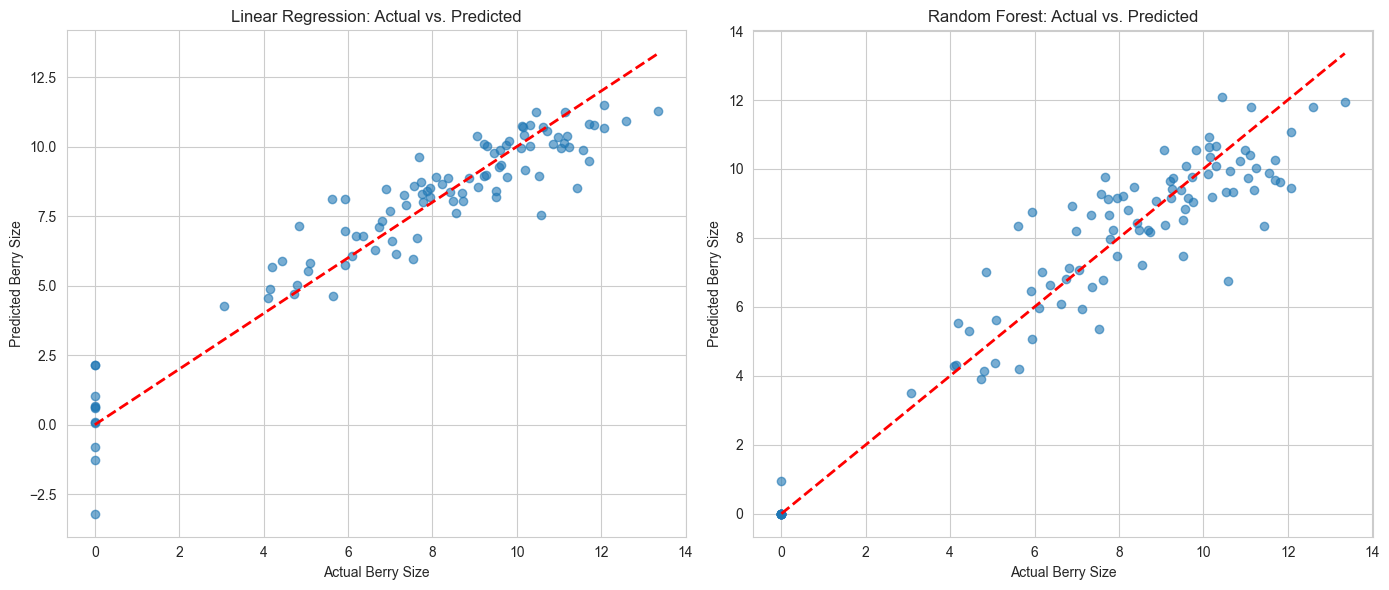

In [33]:
# --- Model 1: Linear Regression ---
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# --- Model 2: Random Forest Regressor ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# --- Evaluation ---
print("--- Full Dataset Prediction ---")
print("\nLinear Regression Performance:")
print(f"  R-squared: {r2_score(y_test, y_pred_lr):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test, y_pred_lr):.4f}")

print("\nRandom Forest Regressor Performance:")
print(f"  R-squared: {r2_score(y_test, y_pred_rf):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test, y_pred_rf):.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.title('Linear Regression: Actual vs. Predicted')
plt.xlabel('Actual Berry Size')
plt.ylabel('Predicted Berry Size')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.title('Random Forest: Actual vs. Predicted')
plt.xlabel('Actual Berry Size')
plt.ylabel('Predicted Berry Size')

plt.tight_layout()
plt.show()


#### Analysis
The Linear regression model & the random forest regressor perform nearly the same, with LR being slightly better.

#### Linear Regression

The blue dots form a reasonably tight, consistent cloud around the red line. The model appears to capture the underlying linear trend quite well across the entire range of berry sizes.

A key flaw: The model predicts values both above and below zero (e.g., -2.5), a limitation of Linear Regression: it simply fits a line and will predict negative sizes if the feature values are low enough. This is nonsensical in the real world.

#### Random Forest: Actual vs. Predicted

The blue dots also follow the red line, but they appear slightly more scattered and less uniform than in the linear regression plot. There isn't a clear pattern to the errors; they seem a bit random, which is characteristic of this model.

Handling of Zero: Notice that the Random Forest model does a much better job at the low end. It correctly predicts a size of 0 for the berries that have an actual size of 0. This is because a tree-based model can learn a hard rule like "if these conditions are met, the size is 0" and is not constrained to a single straight line.
    
The slightly wider spread of dots visually corresponds to the slightly lower R-squared of 0.884. While it's better at handling the boundary condition at zero, it seems to be slightly less precise than the linear model for the majority of the data points in this specific run.

#### 3.2: Predicting for Edible Berries Only
Now, let's focus only on the berries we care about for survival: the edible ones. We will repeat the prediction process using only the subset of data where edible is True.

In [34]:
# --- Predicting for Edible Berries Only ---

# Filter for edible berries
df_edible = df[df['edible'] == True].copy()

# Define features and target for the edible subset
y_edible = df_edible['berry_size']
X_edible = df_edible.drop('berry_size', axis=1)

# Split the edible data
X_train_ed, X_test_ed, y_train_ed, y_test_ed = train_test_split(X_edible, y_edible, test_size=0.2, random_state=42)

# --- Retrain and Evaluate Models on Edible Data ---

# Linear Regression on edible data
lr_pipeline.fit(X_train_ed, y_train_ed)
y_pred_lr_ed = lr_pipeline.predict(X_test_ed)

# Random Forest on edible data
rf_pipeline.fit(X_train_ed, y_train_ed)
y_pred_rf_ed = rf_pipeline.predict(X_test_ed)

# --- Evaluation on Edible Subset ---
print("\n--- Edible Berries Only Prediction ---")
print("\nLinear Regression Performance (Edible):")
print(f"  R-squared: {r2_score(y_test_ed, y_pred_lr_ed):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test_ed, y_pred_lr_ed):.4f}")

print("\nRandom Forest Regressor Performance (Edible):")
print(f"  R-squared: {r2_score(y_test_ed, y_pred_rf_ed):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test_ed, y_pred_rf_ed):.4f}")



--- Edible Berries Only Prediction ---

Linear Regression Performance (Edible):
  R-squared: 0.8617
  Mean Squared Error: 1.4060

Random Forest Regressor Performance (Edible):
  R-squared: 0.8501
  Mean Squared Error: 1.5240


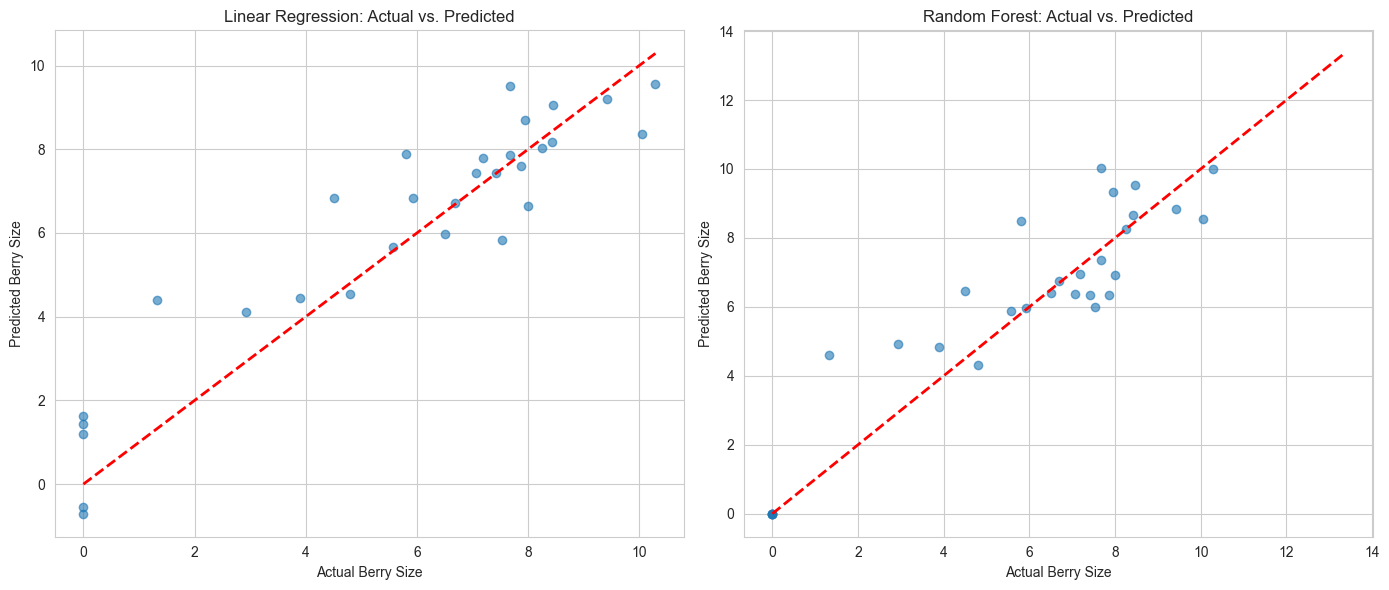

In [35]:
# Visualize the predictions vs actual values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_ed, y_pred_lr_ed, alpha=0.6)
plt.plot([y_test_ed.min(), y_test_ed.max()], [y_test_ed.min(), y_test_ed.max()], '--', color='red', lw=2)
plt.title('Linear Regression: Actual vs. Predicted')
plt.xlabel('Actual Berry Size')
plt.ylabel('Predicted Berry Size')

plt.subplot(1, 2, 2)
plt.scatter(y_test_ed, y_pred_rf_ed, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.title('Random Forest: Actual vs. Predicted')
plt.xlabel('Actual Berry Size')
plt.ylabel('Predicted Berry Size')

plt.tight_layout()
plt.show()

#### Analysis:

Linear Regression:
Just as before, the model predicts negative sizes for berries that have an actual size of 0. This inherent flaw of Linear Regression persists.

The Random Forest again demonstrates its strength at the low end. It correctly predicts a size of 0 for the berries with an actual size of 0. It does not predict impossible negative sizes.

The pattern of the dots seem to form slightly looser clusters. 

Conclusion: Did Focusing on Edible Berries Help?

Performance Change: Comparing these results to the full dataset (Linear R² ≈ 0.89, RF R² ≈ 0.88), we see that the performance of both models slightly decreased when trained only on edible berries. This is contrary to the initial hypothesis that focusing on this subset would improve the prediction.

This likely happened because the model had less data to learn from. By removing the inedible berries, we gave the models fewer examples, making it harder for them to learn the underlying patterns as effectively. The inedible berries, even if we don't eat them, provided useful information about the relationship between a plant's features and the size of its fruit.
    
Model Comparison: The conclusion remains the same as with the full dataset. The Linear Regression model holds a slight edge in overall accuracy (R²), but the Random Forest is more practical and reliable due to its ability to respect the real-world boundary condition of zero.

It is better to train the models on the entire dataset, as it provides more information and leads to slightly higher accuracy. The choice between the Linear Regression and Random Forest models depends on whether you prioritize raw accuracy or physically sensible predictions.

### 3.3: Deriving an Explicit Expression for Berry Size

Goal: To create a predictor that can be used in the wilderness without a computer.

For this we need a simple, explicit formula. A linear regression model is perfect for this.

Use the statsmodels library, which provides a detailed summary including the coefficients for each feature.

Build this model on the edible berries dataset since that is our focus for survival.

In [36]:
# --- Deriving a Field-Ready Formula ---

# Select only the data we want to model, using the full dataset for the most general formula.
# Filter out the rows where berry_size is 0, as they don't help predict a size.
df_formula = df[df['berry_size'] > 0].copy()

# Define the features (X) and target (y)
# Drop 'species' because it is perfectly determined by the other categorical features,
# which can cause multicollinearity issues in a linear model.
features_to_use = ['age', 'leaf_size', 'petal_size', 'height', 'soil_quality',
                   'berry_colour', 'leaf_shape', 'petal_colour', 'edible']
X_formula = df_formula[features_to_use]
y_formula = df_formula['berry_size']

# Convert ALL non-numeric columns to dummies in one step.
# This automatically handles 'berry_colour', 'leaf_shape', 'petal_colour' (object),
# and 'edible' (bool). It will create new numerical columns and drop the originals.
X_formula_encoded = pd.get_dummies(X_formula, drop_first=True)

# Ensure ALL columns are integers or floats. This explicitly converts the
# remaining 'edible' boolean column (and all others) to 0s and 1s.
X_formula_encoded = X_formula_encoded.astype(int)

# 5. Add a constant for the intercept.
X_sm = sm.add_constant(X_formula_encoded)

# 5. Fit the OLS (Ordinary Least Squares) model. This will now work.
model = sm.OLS(y_formula, X_sm).fit()

# --- Analysis and Formula Derivation ---
print("\n--- Linear Regression Model Summary (for Formula Derivation) ---")
print(model.summary())

# --- Construct the formula string ---
print("\n--- Explicit Formula for Berry Size ---")
# Start with the intercept
formula = f"Berry Size = {model.params['const']:.3f}"

# Add the other terms
for feature, coef in model.params.items():
    if feature != 'const':
        sign = "+" if coef >= 0 else "-"
        formula += f" {sign} {abs(coef):.3f} * ({feature})"

print(formula)



--- Linear Regression Model Summary (for Formula Derivation) ---
                            OLS Regression Results                            
Dep. Variable:             berry_size   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     74.42
Date:                Thu, 11 Sep 2025   Prob (F-statistic):           6.21e-92
Time:                        21:06:46   Log-Likelihood:                -720.93
No. Observations:                 438   AIC:                             1466.
Df Residuals:                     426   BIC:                             1515.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

#### Statistically Significant Features (The Ones We Can Trust):

const (Intercept): 3.558: Our baseline predicted berry size is 3.56 units if all other features are zero.

soil_quality: +1.247: a significant predictor. For every one-point increase in soil quality, the berry size is expected to increase by 1.25 units, all else being equal. This confirms our initial finding from the correlation matrix.

edible: -2.466: also significant. If a berry is edible (edible=1), its size is expected to be 2.47 units smaller than an inedible berry, even after accounting for all other factors. This is a substantial penalty.

berry_colour_green: -1.607: Green berries are predicted to be 1.61 units smaller than the baseline berry color (which is likely 'black' or 'blue', as they come first alphabetically).
    
berry_colour_purple: -1.229: Purple berries are predicted to be 1.23 units smaller than the baseline color.

petal_colour_white: +1.468: Having white petals is associated with a 1.47 unit increase in berry size compared to the baseline petal color.

#### Statistically Insignificant Features (The Ones We Can't Rely On):

age, leaf_size, petal_size, height: All of these have high p-values (greater than 0.05). This is a fascinating result. It means that once the model knows the soil_quality and the categorical features, the individual plant measurements like age and height don't provide much additional predictive power in this linear model. Their effects are likely already captured by the other, more dominant variables.

berry_colour_grey and leaf_shape_ovate: These are also not statistically significant, meaning we can't rely on their effect.

#### Multicollinearity

Cond. No. is large, 2.51e+03: This note warns us that some of our features are strongly correlated with each other. For example, we know that soil_quality is related to petal_size. This doesn't ruin the model's overall predictive accuracy, but it can make the individual coefficients less reliable. This is likely another reason why features like height and petal_size appear insignificant—their effects are tangled up with other variables.


### 3.4: Predicting with a Subset of Features

Assessing soil quality in the wild can be difficult. Therefore, it would be beneficial to have a model that can predict berry size without this feature. Let's retrain our Linear Regression model on the edible berries dataset, but exclude soil_quality.

In [ ]:

print("\n Predicting for Edible Berries without 'soil_quality'")

# Prepare the data from the edible-only dataframe
df_edible_subset = df[df['edible'] == True].copy()

# Define features (X) and target (y), excluding 'soil_quality'
y_edible_no_soil = df_edible_subset['berry_size']
X_edible_no_soil = df_edible_subset.drop(['berry_size', 'soil_quality'], axis=1)

# Create the preprocessing pipeline for the reduced feature set
# Identify the new feature types
numerical_features_ns = X_edible_no_soil.select_dtypes(include=np.number).columns.tolist()
categorical_features_ns = X_edible_no_soil.select_dtypes(include=['object', 'category']).columns.tolist()

# The 'edible' column is boolean but will be dropped by the preprocessor if not specified.
# Since we are only using edible data, this column is constant and provides no info,
# so we can safely exclude it.
if 'edible' in numerical_features_ns:
    numerical_features_ns.remove('edible')
if 'edible' in categorical_features_ns:
    categorical_features_ns.remove('edible')


preprocessor_ns = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_ns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ns)
    ],
    remainder='drop' # Drop any columns not specified (like the constant 'edible' column)
)

# Build the Linear Regression pipeline
lr_pipeline_ns = Pipeline(steps=[('preprocessor', preprocessor_ns),
                                 ('regressor', LinearRegression())])

# Split, train, and evaluate the model
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    X_edible_no_soil, y_edible_no_soil, test_size=0.2, random_state=42
)
lr_pipeline_ns.fit(X_train_ns, y_train_ns)
y_pred_lr_ns = lr_pipeline_ns.predict(X_test_ns)

# Evaluate the performance
print("\n--- Linear Regression Performance (Edible, No Soil Quality) ---")
print(f"  R-squared: {r2_score(y_test_ns, y_pred_lr_ns):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test_ns, y_pred_lr_ns):.4f}")




--- Predicting for Edible Berries without 'soil_quality' ---

--- Linear Regression Performance (Edible, No Soil Quality) ---
  R-squared: 0.8422
  Mean Squared Error: 1.6035


When we remove soil quality, we notice that there's a minute difference


Minor Drop in Performance: Removing the soil_quality feature caused the R-squared to decrease from 0.8617 to 0.8422—a drop of only about 2%. This is a very small reduction in the model's overall explanatory power.

Slight Increase in Error: The Mean Squared Error increased from 1.4060 to 1.6035. While this is an increase, it is not a dramatic one. The model's predictions are, on average, only slightly less accurate than before.

This result is surprisingly positive and demonstrates the concept of multicollinearity in action.
Our initial statsmodels summary warned that some features were strongly correlated. The correlation matrix showed that soil_quality was related to other features like petal_size and height. This new result proves that those other features contain enough overlapping information for the Linear Regression model to compensate for the missing soil_quality data.

When the model can no longer use soil_quality directly, it automatically increases the importance (i.e., the coefficients) of the other correlated features like petal_size and height to make up for the loss. It effectively learns to use them as proxies for soil quality.

Conclusion:
The Linear Regression model is surprisingly robust to the removal of the soil_quality feature. While its performance does decrease slightly, the drop is minor. The model can still explain 84.2% of the variance in berry size using only the other, more easily observable features.

This is an excellent outcome for our survivalist. It means that even if they cannot accurately assess the quality of the soil, they can still use a linear model (or a simplified formula derived from it) to get a reasonably accurate and useful prediction of berry size. The model is practical for real-world use, even with a limited feature set.